# Modeling

In this notebook I take what I learned from the exploratory data analysis and feature engineering stages and use it to help me build machine learning models capable of classifying a transaction as normal or fraudulent. I will first import the data and engineer it. Then I will try out several machine learning models including linear models, which include logistic regression and support vector classifiers, tree based models, which include decision tree, random forest, and XGBoost classifiers, and distance based models (K-nearest-neighbors). Along the way I will look at the feature importances to see if I need to make any changes to the engineering process. The modeling process will not include scaling, as the data is most likely already scaled since the source noted the features are a product of principal component analysis. The process will however, include grid searches to hone in on the best hyper-parameters for the models. As for performance metrics, I will use f1-score for the grid search, but my main goal is high recall. The higher the recall score the fewer frauds go undetected. Recall must be balanced with precision, which is equal to the amount of true positives divided by the sum of the amount of true positives and false negatives. essentially the inverse of the rate the model falsely flags normal transactions as fraudulent. My goal is to have recall as high as possible with precision above %20. With the data being only %0.2 frauds, this will mean that I incorrectly flag a transaction as fraud %0.08 of the time.

### Road Map
1) Engineer Data <br>
2) Go Through Each Type of Model I Stated<br>
3) Examine Results For Each Model<br>

In [27]:
# import libraries

# standard scientific libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# train-test split for validation set
from sklearn.model_selection import StratifiedShuffleSplit

# file storage
import pickle

# import the custom functions I created in feature engineering
from custom_functions import slice_feats, resample_data, slice_resample_data

# Principal component analysis
from sklearn.decomposition import PCA

# machine learning models
# linear
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
# tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# distance
from sklearn.neighbors import KNeighborsClassifier

# performance metrics
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

# grid search
from sklearn.model_selection import GridSearchCV

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# create a validation set using stratified shuffle split

# instantiate stratified shuffle split
sss = StratifiedShuffleSplit(test_size=0.1)

# seperate X and y
X = train.drop("Class", axis=1)
y = train.Class

# find indices
train_indices, val_indices = next(sss.split(X, y))

# create validation set
val = train.iloc[val_indices]
train = train.iloc[train_indices]


# preview value counts
val.Class.value_counts(normalize=True)

0    0.998341
1    0.001659
Name: Class, dtype: float64

In [3]:
train.Class.value_counts(normalize=True)

0    0.998332
1    0.001668
Name: Class, dtype: float64

# 1. Engineer Data

Now I will engineer the data as I did in the feature engineering stage. I will create two sets of data, one for linear models, and another for tree based models. Although I will try both sets out on each model. The process involves slicing the data down to a smaller amount of features, resampling the data with the NearMiss algorithm, and for the linear models I will perform Principal Component Analysis.

In [4]:
# import lists of ideal features which were deturmined
# in the feature engineering stage
with open("feature_engineering_notes.pickle", "rb") as file:
    notes = pickle.load(file)
    
notes

{'linear': ['V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18'],
 'tree': ['V11', 'V12', 'V14', 'V16', 'V18']}

In [6]:
# slice and resample data. once for each set:
# linear and tree
lin_X_train, lin_y_train = slice_resample_data(train, notes["linear"])
tree_X_train, tree_y_train = slice_resample_data(train, notes["tree"])

# also set up test and validation data by slicing
lin_X_val, lin_y_val = slice_feats(val, notes["linear"])
lin_X_test, lin_y_test = slice_feats(test, notes["linear"])

tree_X_val, tree_y_val = slice_feats(val, notes["tree"])
tree_X_test, tree_y_test = slice_feats(test, notes["tree"])

In [7]:
# perform principal component analysis on
# the linear data.
# make sure to fit to training data and
# not to fit to validation and testing data
pca = PCA(n_components=3)
lin_pca_X_train = pca.fit_transform(lin_X_train)
lin_pca_X_val = pca.transform(lin_X_val)
lin_pca_X_test = pca.transform(lin_X_test)

In [9]:
# put data into a dictionary to help with automation
data = {}

# linear data
data["lin"] = {
    "X_train":lin_X_train,
    "y_train":lin_y_train,
    "X_val":lin_X_val,
    "y_val":lin_y_val,
    "X_test":lin_X_test,
    "y_test":lin_y_test
}

# tree data
data["tree"] = {
    "X_train":tree_X_train,
    "y_train":tree_y_train,
    "X_val":tree_X_val,
    "y_val":tree_y_val,
    "X_test":tree_X_test,
    "y_test":tree_y_test
}

# linear data w/ PCA
data["lin_pca"] = {
    "X_train":lin_pca_X_train,
    "y_train":lin_y_train,
    "X_val":lin_pca_X_val,
    "y_val":lin_y_val,
    "X_test":lin_pca_X_test,
    "y_test":lin_y_test
}

# 2. Go Through Each Type of Model

For each model I will try out all three types of data (data for linear models, data for tree models, and PCA transformed data for linear models). I will also conduct grid searches to find the optimal hyperparameters for the models.  Finally for each model I will examine the results and see if anything can be improved. Hyper-parameters are like settings for the model. They can be changed by the machine learning engineer, but are not impacted by the values of the data.<br><br>
Again the models I will experiment with are:<br>
1) Logistic Regression <br>
2) Support Vector Classifier<br>
3) Decision Tree<br>
4) Random Forest<br>
5) XGBoost Classifier<br>
6) K-Nearest-Neighbors<br>

## 2.1 Logistic Regression

Logistic Regression works by setting a coefficient for each feature along with a bias (Much like slope and y intercept). It then takes a logorithm to calculate a probability. It then labels the prediction as either 1 or 0 depending on whether the probability meets a certain threshold (default threshold is 0.5). This algorithm is very simple and rather robust to overfitting. The only hyperparameter I will be tuning is the "C" value, which is the inverse of the learning rate (a value that deturmines how fast the coefficients are tuned).

In [16]:
# create a function for performing a 
# grid search on each type of data
def automated_grid_search(clf, params):
    
    # iterate over each type of data
    for key in ["lin", "lin_pca", "tree"]:
        
        # fit and predict using a grid search object
        
        # instantiate grid search with classifier and paramater grid
        gscv = GridSearchCV(clf, params, scoring="f1")
        
        # fit
        gscv.fit(data[key]["X_train"], data[key]["y_train"])

        # print key
        print("\n\n", key, "\n\n")
        
        # print training f1-score
        print(f"Training F1-Score: {gscv.best_score_}")
        
                
        # predict
        predictions = gscv.predict(data[key]["X_val"])
        
        # print validation f1-score
        score = f1_score(data[key]["y_val"], predictions)
        print(f"Validation F1-Score: {score}")
        
        # print parameters
        print(f"Best parameters {gscv.best_params_}\n\n")
        

In [17]:
# conduct grid searches

# create a parameter grid using
# "C" the inverse of the learning rate
linear_params = {
    "C":[0.1, 1, 10]
}

# conduct automated grid search
# pass in a logistic regression object
automated_grid_search(LogisticRegression(), linear_params)



 lin 


Training F1-Score: 0.9249533644667342
Validation F1-Score: 0.09887005649717513
Best parameters {'C': 0.1}




 lin_pca 


Training F1-Score: 0.9166349900137004
Validation F1-Score: 0.21153846153846154
Best parameters {'C': 10}




 tree 


Training F1-Score: 0.944855039927288
Validation F1-Score: 0.010236547240282197
Best parameters {'C': 0.1}




C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbf

It seems that the model is over-fitting a bit with the low "C" parameter. I will redo the process with a different parameter grid.

In [19]:
# set the parameter grid to have higher values
linear_params = {
    "C": [10, 50, 100]
}

# conduct grid search
automated_grid_search(LogisticRegression(), linear_params)



 lin 


Training F1-Score: 0.9234040576370424
Validation F1-Score: 0.07580824972129321
Best parameters {'C': 10}




 lin_pca 


Training F1-Score: 0.9166349900137004
Validation F1-Score: 0.21153846153846154
Best parameters {'C': 10}




 tree 


Training F1-Score: 0.9431594881119505
Validation F1-Score: 0.008944099378881989
Best parameters {'C': 10}




C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

It seemsed the linear data that was PCA transformed did the best. Now I will examine to see if a precision-recall tradeoff could help. I will create a plot to show all the possible recall and precision scores on the validation set if a different probability threshold was used. I will also create a function for automating this plot in the future.

In [31]:
# create a set of functions for plotting the precision recall tradeoff

# function for making predictions with an altered probability
# threshold
# the function will need to know what type of classifier,
# the probability threshold we are using to predict instead of
# the default (%50), what form of data we are using
# (i.e. the linear data or the tree data or the PCA data),
# as well as whether to return the training, validation, or
# testing predictions
def predict_using_threshold(clf, threshold, data_form, data_set):
    """
    clf: a machine learning classifier
    data_form: string representing whether data is enfineered for linear, tree, ect.
    data_set: string representing what set to predict on (train, validation, or test)
    """
    # fit classifier
    clf.fit(data[data_form]["X_train"], data[data_form]["y_train"])
    
    # get probabilities
    probabilities = clf.predict_proba(data[data_form]["X_" + data_set])[:, 1]
    
    # predict using new threshold
    predictions = [0 if p < threshold else 1 for p in probabilities]
    
    return predictions

# function to plot precision-recall tradeoff using the validation set
# takes in a classifier and
# the form of the data: i.e. lin, tree, lin_pca,
def precision_recall_tradeoff_plot(clf, data_form):
    """
    function to plot precision-recall tradeoff using the validation set
    takes in a classifier and the form of the data. 
    eligible values: lin, tree, lin_pca,
    """
    # generate 100 thesholds between 0 and 1
    thresholds = np.linspace(0, 1, 100)
    
    # create a space to store precision and recall scores
    precisions = []
    recalls = []
    
    
    # iterate over thresholds
    for threshold in thresholds:
        
        # get predictions (see above function)
        predictions = predict_using_threshold(clf, threshold, data_form, "val")
        
        # get and store precision and recall scores
        precisions.append(precision_score(data[data_form]["y_val"], predictions))
        recalls.append(recall_score(data[data_form]["y_val"], predictions))
        
        
    # generate the final plot
    plt.figure(figsize=(15, 5))
    plt.plot(thresholds, precisions, label="precision")
    plt.plot(thresholds, recalls, label="recall")
    plt.xlabel("threshold")
    plt.ylabel("score")
    plt.title("precision_recall_tradeoff")
    plt.legend()
    plt.show()

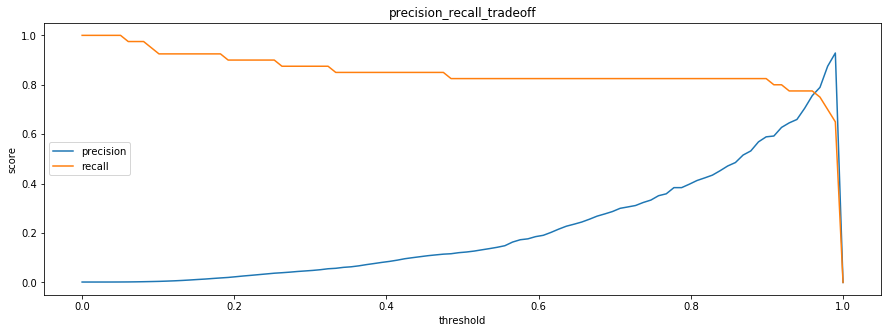

In [32]:
# make plot for logistic regression C=10 with linear PCA transformed data

# set logistic regression parameters
clf = LogisticRegression(C=10)

# plot
precision_recall_tradeoff_plot(clf, "lin_pca")

It seems like the best threshold would be around 0.6. This way I can reach my goal of atleast %20 precision.

## 2.2 Support Vector Classifier